# Speech classification and trigger word detection with MFCC

## 1. Introduction

This project aims to detect a particular spoken word in an Audio signal.

The detection of this word can be used to trigger an action (emitting a sound or lighting an LED, etc.), hence the term "trigger word". It is also called "wake word" or "hot word".

We can imagine the problem as a simple binary classification problem, 1 if the word is pronounced, 0 if another word is pronounced.

Therefore wz need to find a dataset containing several words in *.wav”* file format. each word should be said by different people in different conditions.

Then, using this data set, we can choose a particular word as our trigger word, and train an algorithm to recognize this particular word.

# 2. Dataset

Tensorflow has the dataset **"speech_command"** that contains thousands of raw audio files *".wav"* with a duration of 1s each. every audio file corresponds to a given word.  
The dataset can be found on Tensorflow website, here : https://www.tensorflow.org/datasets/catalog/speech_commands  
or on Kaggle website, here : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

The advantage of this dataset is that the audios were not recorded in a studio, therefore the audios may have different background noises. 
Other important information are :
- the audios are all one second long
- the sampling rate is 16000 Hz or sample/s

Now let's explore the contents of the "speech command" folder:

In [2]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [4]:
# you need to download the file first
path = "speech command"
dir_list = os.listdir(path)
print(dir_list)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


We then notice that we have several sub-folders, each referring to a different word (different class).  
There is also a "_background_noise_" folder, which we will ignore for the moment.  
Let's explore the contents of these files:

In [7]:
mots = dir_list[0:-1]
file_nb = list()
n=0

for d in dir_list[0:-1]:
    f_list = os.listdir(join(path, d))
    m=0
    
    for f in f_list:      
        if f.endswith(".wav"):
            m += 1
            n += 1
    
    file_nb.append(m)

print("number of words : ", len(mots))
print("nb of wav files : ", n)

number of words :  30
nb of wav files :  64721


Let's find out how many files per word

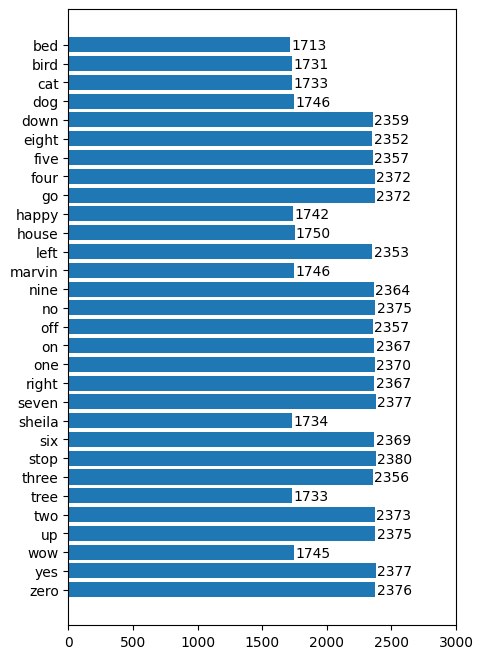

In [8]:
nb_mots = np.array(file_nb)
ratio_mots = np.round(nb_mots*100 /n, 1)

plt.figure(figsize=(5,8))
plt.xlim(0, 3000)
plt.barh(mots, nb_mots)

for i in range(len(mots)):
    plt.text(nb_mots[i]+10, i+0.25,nb_mots[i])
plt.gca().invert_yaxis()
plt.show()

So we have **30** words in total, accumulating **64721** files,  
Some words have around 1700 records, others have around 2400 records.  

Let's take an example sample and find its characteristics

In [9]:
# mot clé
trig_wor = "one"
file_path = join(path, trig_wor)
file_list = os.listdir(file_path)
file_list[-5:]

['ffd2ba2f_nohash_0.wav',
 'ffd2ba2f_nohash_1.wav',
 'ffd2ba2f_nohash_2.wav',
 'ffd2ba2f_nohash_3.wav',
 'ffd2ba2f_nohash_4.wav']

We can also listen to the file :

In [11]:
sample_path = join(file_path, '1890e5c3_nohash_0.wav')
ipd.Audio(sample_path)

In [12]:
import wave

In [13]:
with wave.open(sample_path, "r") as af:
    nchannels, sampwidth, framerate, nframes, _, _ = af.getparams()

In [14]:
print("Number of channels (1:mono, 2:stereo) :", nchannels)
print("sample width in bytes :", sampwidth) 
print("sampling rate :", framerate)
print("Number of samples :", nframes)

Number of channels (1:mono, 2:stereo) : 1
sample width in bytes : 2
sampling rate : 16000
Number of samples : 16000


The sampling frequency is indeed 16000 Hz as stated in the Dataset page.  
and the file has a duration of 1s, then it contains 16000 samples.  
let's check that all files have the same characteristics.  
the following code looks for files that do not have the same characteristics:

In [15]:
# paramètres à vérifier
framerate = 16000
nframes = 16000
mauvais_fichier = list()
bon_fichier = list()

path = "speech command"
dir_list = os.listdir(path)

for d in dir_list[0:-1]:
    file_path = join(path,d)
    file_list = os.listdir(file_path)
    
    for f in file_list:
        wave_path = join(file_path, f)
        with wave.open(wave_path, "r") as af:
            nc, sw, fr, nf, _, _ = af.getparams()
        
        if (fr !=framerate) or (nf != nframes):
            #print(wave_path, fr, nf)
            mauvais_fichier.append(wave_path)
        else :
            bon_fichier.append(wave_path)

In [16]:
print("number of Different files : ", len(mauvais_fichier) *100 / 64721, "%")
print("number of similar files :", len(bon_fichier) *100 / 64721, "%")

number of Different files :  9.995210209978215 %
number of similar files : 90.00478979002179 %


about 10% of the files have a length different then 16000 sample, let's take an example :

In [17]:
error_file ="speech command\\happy\\5eb5fc74_nohash_0.wav"
ipd.Audio(error_file)

# Learning approaches

We will try two diffrent approaches :
- a classification approach
- a detecion approach

## 1. Approach 1 : Classification

Let's consider for the moment only files with exactly 1s duration (corresponding to 16000 frame), so we don't need padding. Let us also consider the word "one" as our trigger word.  
The main idea is to prepare a balanced dataset, where we have for example 1500 examples of the word "one", and 1500 files of other examples (we will take 50 examples of other existing words). each record corresponding to "one" will have **1** as label, and each word different from "one" will have a label of **0**.

In [18]:
path = "speech command"
dir_list = os.listdir(path)

one_list = list()
other_list = list()

for d in dir_list[0:-1]:
    file_path = join(path,d)
    file_list = os.listdir(file_path)
    m=0
    n=0
    
    if d =="one":

        
        for f in file_list:
            wave_path = join(file_path, f)

            
            if wave_path in bon_fichier:
                one_list.append(wave_path)
                n+=1
            
            if n == 1500:
                break
                    
    else:            

        for f in file_list:
            wave_path = join(file_path, f)

            
            if wave_path in bon_fichier:
                other_list.append(wave_path)
                m+=1
            
            if m == 52:
                break

In [19]:
print(len(one_list))
print(len(other_list))

1500
1508


We then have a dataset of 3000 records, of which around 50% are the trigger word and 50% are another word.

### 1.1 MFCC features

Usually in speech recognition spectrograms are used as input for the ML algorithm, as it contains both time and frequency data. But a more advanced approach is to extract the **MFCC** parameters of the speech signal.

Let's try it with one example:

In [20]:
sample = one_list[0]
sample_rate = 16000

In [23]:
import librosa
import python_speech_features

In [24]:
sig, fs = librosa.load(sample, sr = sample_rate)

Let's extract the MFCC features

In [25]:
sample_mfcc = python_speech_features.mfcc(sig)

In [26]:
print("Output size : ", sample_mfcc.shape)
print(sample_mfcc[0])

Output size :  (99, 13)
[ -7.27574748 -41.03589814 -14.01574478 -13.96824668 -33.21683684
  16.12425824   1.25911944  30.20846334   6.78743515   8.77447925
 -21.77290762 -26.56179478   4.377118  ]


This function returns **"NUMFRAMES by numcep"**, in other words we obtain 99 frames with 13 MFCC parameters each.

Let's visualize the heatmap of this output :

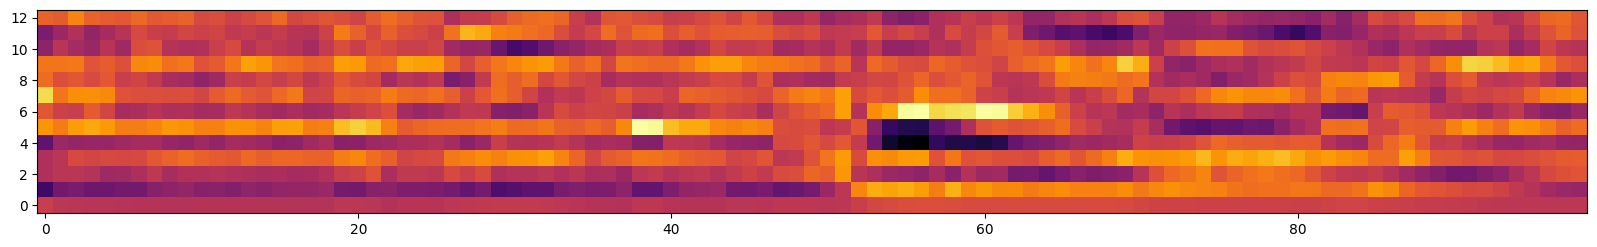

In [27]:
fig= plt.figure(figsize=(20,20))
plt.imshow(sample_mfcc.T, cmap = 'inferno', origin ='lower')

Let's now see the range of the amplitudes :

In [29]:
print("min :", sample_mfcc.min())
print("max :", sample_mfcc.max())
print("moy :", sample_mfcc.mean())
print("std :", sample_mfcc.std())

min : -60.6722888576143
max : 39.159743735343916
moy : -5.465618071671132
std : 13.798308320202795


This shows that our amplitudes can vary by quite a lot, this means that we will need to normalize these amplitudes before training.

## 1.2 Preparing data set

In [30]:
# sample the trigger word
for i, f in enumerate(one_list):
    sig, fs = librosa.load(f, sr = sample_rate)
    
    x_tmp = np.expand_dims(sig, axis =[0,2])
    
    if i ==0:
        x_data = x_tmp
        y_data = 1.0
    
    else:
        x_data = np.append(x_data, x_tmp, axis=0)
        y_data = np.append(y_data, 1.0)

# sample the different words
for f in other_list:

    try:
        sig, fs = librosa.load(f, sr = sample_rate)
        x_tmp = np.expand_dims(sig, axis =[0,2])

        x_data = np.append(x_data, x_tmp, axis=0)
        y_data = np.append(y_data, 0.0)
    except:
        print(f)

In [31]:
print(x_data.shape , y_data.shape)

(3008, 16000, 1) (3008,)


In [26]:
# np.save("x_data.npy", x_data)
# np.save("y_data.npy", y_data)

## 1.3 Preprocessing

In [32]:
# import os
# from os.path import join
# import numpy as np
# import matplotlib.pyplot as plt

# import librosa
# import python_speech_features

# import IPython.display as ipd
np.random.seed(45)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [34]:
# x_data = np.load("x_data.npy")
# y_data = np.load("y_data.npy")
#y_data = np.expand_dims(y_tmp, axis = 1)
print(x_data.shape , y_data.shape)

(3008, 16000, 1) (3008,)


Given that we will try several algorithms, we will need data for training, for validation and for a final test.

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, shuffle = True, stratify = y_data)

In [36]:
print(x_train.shape, y_train.shape)

(2105, 16000, 1) (2105,)


## 1.4 MFCC feature extraction

Here we will extarct the MFCC coefficients for all the files, and as indicated previously, the MFCC-spectrogram has 2 dimensions, We will need then to flatten the spectrogram matrix into a vector.

In [37]:
for i, sig in enumerate(x_train):    
    x_train_mfcc = python_speech_features.mfcc(sig)
    tmp = x_train_mfcc.reshape((1, x_train_mfcc.shape[0]*x_train_mfcc.shape[1]))
    if i ==0:
        x_train_final = tmp
    else:
        x_train_final = np.append(x_train_final, tmp, axis =0)

In [38]:
print(x_train_final.shape)

(2105, 1287)


In [39]:
x_train_final[0].shape

(1287,)

## 1.5 Training

### 1.5.1. Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
LR = LogisticRegression(random_state=0).fit(x_train_final, y_train)

C:\Users\ndd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
train_acc = LR.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc*100), "%")

train_accuracy :  100 %


## 1.5.2. Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
RF = RandomForestClassifier()
RF.fit(x_train_final, y_train)

RandomForestClassifier()

In [46]:
train_acc_RF = RF.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc_RF*100), "%")

train_accuracy :  100 %


## 1.5.3. SVM

In [47]:
from sklearn.svm import SVC

We will try also several Kernels for SVM

#### Linear Kernel

In [48]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(x_train_final, y_train)
train_acc_svm = svm_linear.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc_svm*100), "%")

train_accuracy :  100 %


####  "rbf" or Radial Basis Function Kernel

In [49]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(x_train_final, y_train)
train_acc_svm = svm_rbf.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc_svm*100), "%")

train_accuracy :  98 %


#### "poly" Kernel

In [50]:
svm_poly = SVC(kernel='poly')
svm_poly.fit(x_train_final, y_train)
train_acc_svm = svm_poly.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc_svm*100), "%")

train_accuracy :  99 %


#### "sigmoid" Kernel

In [51]:
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(x_train_final, y_train)
train_acc_svm = svm_sigmoid.score(x_train_final, y_train)
print("train_accuracy : ", int(train_acc_svm*100), "%")

train_accuracy :  70 %


### 1.6. Test set

Let's extract the MFCC features

In [52]:
for i, sig in enumerate(x_test):    
    x_test_mfcc = python_speech_features.mfcc(sig)
    tmp = x_test_mfcc.reshape((1, x_test_mfcc.shape[0]*x_test_mfcc.shape[1]))
    if i ==0:
        x_test_final = tmp
    else:
        x_test_final = np.append(x_test_final, tmp, axis =0)

## Test accuracy

We compute the accuracy of each model on the test set :

In [53]:
test_acc_LR = LR.score(x_test_final, y_test)
test_acc_RF = RF.score(x_test_final, y_test)

test_acc_svm_linear  = svm_linear.score(x_test_final, y_test)
test_acc_svm_rbf     = svm_rbf.score(x_test_final, y_test)
test_acc_svm_poly    = svm_poly.score(x_test_final, y_test)
test_acc_svm_sigmoid = svm_sigmoid.score(x_test_final, y_test)

In [54]:
print("test_accuracy LR : ", int(test_acc_LR*100), "%")
print("test_accuracy RF : ", int(test_acc_RF*100), "%")
print("test_accuracy SVM linair : ", int(test_acc_svm_linear*100), "%")
print("test_accuracy SVM RBF: ", int(test_acc_svm_rbf*100), "%")
print("test_accuracy SVM Poly : ", int(test_acc_svm_poly*100), "%")
print("test_accuracy SVM  Sigmoid: ", int(test_acc_svm_sigmoid*100), "%")

test_accuracy LR :  73 %
test_accuracy RF :  86 %
test_accuracy SVM linair :  73 %
test_accuracy SVM RBF:  90 %
test_accuracy SVM Poly :  92 %
test_accuracy SVM  Sigmoid:  70 %


In this classification approach, **SVM** has the best accuracy, especially using *Poly* et *rbf* kernels

# 2. Approche 2 : Detection

We can approach the problem another way, in fact we can take background noises of a type *Backgroud sound* of sufficient length to insert several words, positive words (our trigger word) and negative words.
at this point the problem will no longer be a classification problem, but rather detection of the position of the positive word in the audio clip.  
In this appraoch, we will stack over the background sounds several non-overlapping words, we will use the library **pydub** for that.  
The goall is to train a model to detect only the trigger in a record full of other words.

In [58]:
path = "speech command"
dir_list = os.listdir(path)

one_list = list()
other_list = list()

for d in dir_list[0:-1]:
    file_path = join(path,d)
    file_list = os.listdir(file_path)
    m=0
    n=0
    
    if d =="one":

        
        for f in file_list:
            wave_path = join(file_path, f)

            
            if wave_path in bon_fichier:
                one_list.append(wave_path)
                n+=1
            
            if n == 1500:
                break
                    
    else:            

        for f in file_list:
            wave_path = join(file_path, f)

            
            if wave_path in bon_fichier:
                other_list.append(wave_path)
                m+=1
            
            if m == 52:
                break

This approach will require preparing another dataset composed of background noise clips in which we have inserted positive words and negative words.
The label associated with each audio clip must be the number of the frame immediately after which the positive word is spoken.

Since we will try to detect the word at the end of the frame sequence, we can use a type of recurrent neural network (RNN) such as GRU or LSTM.

## 2.1. Background Noise

Let's explore the folder containing the background noises

In [59]:
back_path = "speech command//_background_noise_"
dir_list = os.listdir(back_path)
print(dir_list)

['doing_the_dishes.wav', 'dude_miaowing.wav', 'exercise_bike.wav', 'pink_noise.wav', 'README.md', 'running_tap.wav', 'white_noise.wav']


In [60]:
bk_sample_path = join(back_path, dir_list[1])
ipd.Audio(bk_sample_path)

In [62]:
with wave.open(bk_sample_path, "r") as af:
    nchannels, sampwidth, framerate, nframes, _, _ = af.getparams()
    
print("Nb of channels (1:mono, 2:stéréo) :", nchannels)
print("sample width in bytes :", sampwidth) 
print("sampling rate :", framerate)
print("Nb of samples :", nframes)
print("duration :", round(nframes/framerate), " s")

Nb of channels (1:mono, 2:stéréo) : 1
sample width in bytes : 2
sampling rate : 16000
Nb of samples : 988891
duration : 62  s


the sample contains a little more than 1 minute of random background noise. It has the same frame rate as the words files.  
If we want to test the model on real audio, it is appropriate to train the algorithm on small sequences (audio clips), say 5 seconds. We therefore need to extract 5 random seconds of different background noises.

In [63]:
positif = AudioSegment.from_wav(one_list[20])
negatif = AudioSegment.from_wav(other_list[20])
bkg_snd = AudioSegment.from_wav(bk_sample_path)

Let's extarct a random 5s background noise

In [64]:
length_ms = len(bkg_snd)
n = random.randint(0,length_ms-5000)
short_clip = bkg_snd[n : n +5000]
len(short_clip)

5000

let's stack a word starting from second 3

In [65]:
train_example = short_clip.overlay(positif, position=1000)
train_example = train_example.overlay(negatif, position=3000)

In [66]:
ipd.Audio(train_example.get_array_of_samples(), rate = 16000)

Let's make it random, and stack 2 non-overlapping words.

In [67]:
random_position = random.randint(0,len(short_clip)-1000)
nb = 2    

Let's test overlapping

In [69]:
for i in range(5):
    start = random.randint(0,len(short_clip)-1000)
    train_samp_2 = short_clip.overlay(positif, start)
    previous_start = start
    previous_end = start+1000
    start_2 = random.randint(0,len(short_clip)-1000)
    end_2 = start_2+1000

    #test chevauchement
    if (start_2 <= previous_end) and (end_2 >= previous_start):
        print("overlap")
    else:
        print(previous_start, previous_end, start_2, end_2)

overlap
overlap
726 1726 3108 4108
1118 2118 3969 4969
overlap


Let's also test the volume level of the background noises 

In [72]:
background_list = [x for x in dir_list if x.endswith(".wav")]

In [73]:
background_list

['doing_the_dishes.wav',
 'dude_miaowing.wav',
 'exercise_bike.wav',
 'pink_noise.wav',
 'running_tap.wav',
 'white_noise.wav']

In [74]:
background_path = join(path, "_background_noise_")
tmp_list = os.listdir(background_path)
# eviter les fichiers non wav
background_list = [x for x in tmp_list if x.endswith(".wav")]

for bkg in background_list:
    bkg_file = join(background_path, bkg)
    bkg_raw = AudioSegment.from_wav(bkg_file)
    print(bkg, bkg_raw.dBFS)

doing_the_dishes.wav -28.54627692518333
dude_miaowing.wav -48.03013165305762
exercise_bike.wav -32.64713152768056
pink_noise.wav -9.560468740381886
running_tap.wav -23.296286534015266
white_noise.wav -9.554096113802512


We notice that some sounds have a high volume, it will be necessary to reduce the volume later when creating the dataset, in order to prevent the bakground sound from hiding the word.

## 2.3. Building the dataset

In this approach, we no longer need to ensure that each clip of a given word is exactly 1s long. we therefore have more freedom in the choice of files.
We must then:
- take a random background noise
- extract 5s randomly
- correct the volume if necessary
- take a positive word at random
- insert it into the clip in a random position
- take a negative word at random
- insert it in a random position without overlapping with the positive word

Directory information

In [75]:
path = "speech command"
dir_list = os.listdir(path)
#print(dir_list)

trigger_word = "one"
positif_path = join(path, trigger_word)
positif_list = os.listdir(positif_path)

background_path = join(path, "_background_noise_")
tmp_list = os.listdir(background_path)
# eviter les fichiers non wav
background_list = [ x for x in tmp_list if x.endswith("wav")]

# vu qu'il y a plusieurs mots négatifs,on crée une liste des mots
negatif_words = [ x for x in dir_list if ((x != trigger_word) and (x!="_background_noise_"))]

We build a dataset of 2000 examples

In [76]:
nb_examples = 2000
y_data = []

for j in range(nb_examples):
    a = random.randint(0,len(positif_list)-1)
    c = random.randint(0,len(background_list)-1)
   
    # générer liste
    d = random.randint(0,len(negatif_words)-1)
    negatif_path = join(path, negatif_words[d])
    negatif_list = os.listdir(negatif_path)
    
    # indice aléatoir
    b = random.randint(0,len(negatif_list)-1)
    
    # choix aléatoire de fichiers
    positif_file = join(positif_path, positif_list[a])
    negatif_file = join(negatif_path, negatif_list[b])
    bkg_file = join(background_path, background_list[c])
    
    # lecture fichiers    
    positif = AudioSegment.from_wav(positif_file)
    negatif = AudioSegment.from_wav(negatif_file)
    bkg_raw = AudioSegment.from_wav(bkg_file)
    #bkg_raw = bkg_raw.set_frame_rate(16000)
    
    # génération mini clip
    n = random.randint(0,len(bkg_raw)-5000)
    background = bkg_raw[n : n +5000]
    
    # reduire volume background si très grand
    if background.dBFS > -10:
        background = background - 30
    
    # génération exemple
    start_1 = random.randint(0,len(background) - len(positif)-1)
    end_1 = start_1 + len(positif)
    
    y_tmp = end_1 + 1
    
    train_sample = background.overlay(positif, start_1)
      
    # ajout de mot negatif
    condition = True
    
    while condition:
        start_2 = random.randint(0,len(background) - len(negatif)-1)
        end_2 = start_2 + len(negatif)

        #test chevauchement
        if (start_2 <= end_1) and (end_2 >= start_1):
            pass
        else:
            train_sample = train_sample.overlay(negatif, start_2)
            condition = False
              
    # normalisation du volume
    objectif = -20
    reel = train_sample.dBFS
    train_sample = train_sample.apply_gain(reel - objectif)
    
    # extraction du np_array
    train_sample_array = train_sample.get_array_of_samples()
    
    x_tmp = np.expand_dims(train_sample_array, axis = 0)

    if j == 0:
        x_data = x_tmp
    else:
        x_data = np.append(x_data , x_tmp, axis =0)
    
    y_data.append(y_tmp)
    

In [77]:
print(x_data.shape, len(y_data))

(2000, 80000) 2000


In [78]:
np.array(y_data).shape

(2000,)

In [80]:
# np.save("x_data_app3.npy", x_data)
# np.save("y_data_app3.npy", np.array(y_data))

### 1.4. Preprcoessing 

In [81]:
# x_data = np.load("x_data_app3.npy")
# y_data = np.load("y_data_app3.npy")
#y_data = np.expand_dims(y_tmp, axis = 1)
#print(x_data.shape , y_data.shape)

In [82]:
# from sklearn.model_selection import train_test_split
# import librosa
# import python_speech_features
import math

np.random.seed(45)

Since we plan to use deep learning, we will not need to flatten the spectrogram

In [83]:
for i, sig in enumerate(x_data):    
    x_data_mfcc = python_speech_features.mfcc(sig)
    tmp = np.expand_dims(x_data_mfcc, axis = 0)
    if i ==0:
        x_data_2 = tmp
    else:
        x_data_2 = np.append(x_data_2, tmp, axis =0)
        
x_data_2.shape

(2000, 499, 13)

Let's listen to an example

In [109]:
idx = 2
exemple = x_data[idx]
print("le mot one se termine à la seconde ", y_data[0]/1000 )
ipd.Audio(exemple, rate = 16000)

le mot one se termine à la seconde  3.053


Lets' extract and visualize the MFCC features

In [110]:
exemple_mfcc = x_data_2[0].reshape((499, 13))

The trigger word ends at  368.0


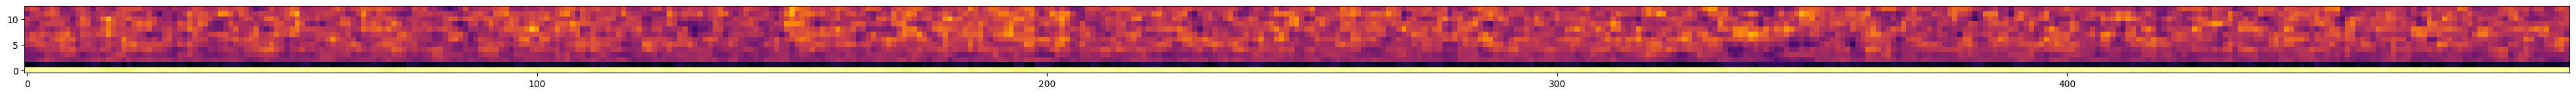

In [111]:
print("The trigger word ends at ", y_data[idx]/10 )
fig= plt.figure(figsize=(50,15))
plt.imshow(exemple_mfcc.T, cmap = 'inferno', origin ='lower')

we can visually verify on the spectrogram that the keyword ends at the indicated end time.

### 1.6. Labels

Now let's prepare our y-labels, each value of the vector Y contains the end position of the trigger word.  

Also we are considering using a seq-to-seq RNN.
Our labels are numeric values, while the RNN will expect a vector of 500 values as output. we will have to encode our Y into one-hot vectors. The only problem in this cas is that we will have a vector full of zeros with a unique value of 1 at the ending postion of the trigger word.

To make it easier for the algortihme to detect the word, and as we do not need an accyracy up to 1/500, we can allow the a series of 1 after the ending position of the trigger word. 


In [112]:
error_idx = []

for i, v in enumerate(y_data):
    
    init_vec = np.zeros((499,1))
    position = math.ceil(v/10)
    
    try :
        for j in range(position, position +10):
            init_vec[j] = 1

    
        y_tmp = np.expand_dims(init_vec, axis = 0)

        if i ==0:
            y_data_final = y_tmp
        else:
            y_data_final = np.append(y_data_final, y_tmp, axis=0)
        
    except:
        # show instances were it wasn't possible to make a sample
        error_idx.append(i)

y_data_final.shape

(1946, 499, 1)

**error_idx** show instances were it wasn't possible to make a sample, therfore we must ignore those samples

In [114]:
x_data_final = np.delete(x_data_2,error_idx, axis = 0)
x_data_final.shape

(1946, 499, 13)

### 2.7 Train test split

In [115]:
x_train, x_tmp, y_train, y_tmp = train_test_split(x_data_final, y_data_final, test_size = 0.2, shuffle = True, random_state=98)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size = 0.5, shuffle = True)
print(x_train.shape, y_train.shape)

(1556, 499, 13) (1556, 499, 1)


# Model

For this model we will use LSTM

In [116]:
from tensorflow.keras import layers, models

In [117]:
input_shape = (x_train.shape[1], x_train.shape[2])

# build network topology
model = models.Sequential()

# 2 LSTM layers
model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation = "sigmoid"))

In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 499, 64)           19968     
                                                                 
 dropout (Dropout)           (None, 499, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 499, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 499, 64)           0         
                                                                 
 dense (Dense)               (None, 499, 1)            65        
                                                                 
Total params: 53,057
Trainable params: 53,057
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=150)

**The final model was trained on colab for 150 epochs**

In [120]:
model = models.load_model("mylstm.h5")

### 1.8 Evaluation

We evalute the model on the test 

In [127]:
pred_stat = model.evaluate(x_test, y_test)
print ("Test Accuracy = {0:.2f} %".format(pred_stat[1]*100))

7/7 [==============================] - 23s 3s/step - loss: 0.1702 - accuracy: 0.9762
Test Accuracy = 97.62 %


We can visualize the result on a given example

259


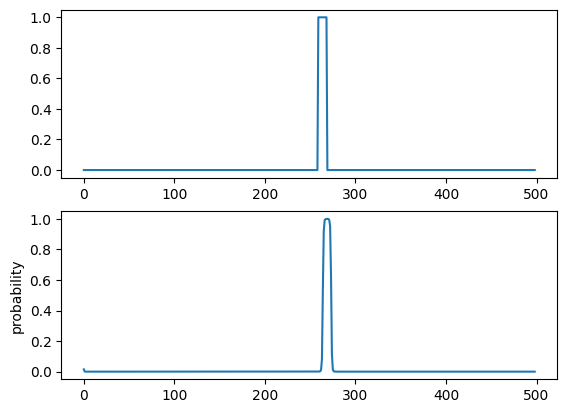

In [128]:
idx = 20
print(y_test[idx].argmax())

plt.subplot(2, 1, 1)
plt.plot((y_test[idx]))

plt.subplot(2, 1, 2)
plt.plot(preds[idx,:,0])
plt.ylabel('probability')
plt.show()

# Conlusion

In this work I show case how we can handle speech data and use different approaches to tackle a problem.    
1- Approach 1 was **classification** of words, using machine learning.  
2- Approach 2 was **Detection** of a word usin deep recurrent neural networks (LSTM).  
Given an intial dataset, I build train and test sets for each approach.  
I used an advanced speech features **MFCC** rather than using spectrograms.  
Both approaches had satisfactory results.  